# Detection d'Intention avec CamemBERT (Transformers)

**Notebook optimise pour Google Colab GPU avec Transformers**

Ce notebook utilise CamemBERT pour :
1. Classification d'intent (TRIP, NOT_TRIP, UNKNOWN, NOT_FRENCH)
2. Named Entity Recognition (Departure, Destination)

**Ameliorations par rapport au baseline TF-IDF** :
- Comprehension semantique profonde du texte
- Detection precise des langues etrangeres
- NER contextuel (pas juste un gazetteer)
- Fine-tuning sur donnees francaises

In [1]:
# Verification GPU et installation des dependances
import torch

print('='*70)
print('DETECTION INTENTION - Transformers + CamemBERT')
print('='*70)

print(f'\nPyTorch version: {torch.__version__}')
print(f'CUDA disponible: {torch.cuda.is_available()}')

if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memoire GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB')
else:
    print('ATTENTION: Pas de GPU detecte!')
    print('Allez dans Runtime > Change runtime type > GPU')

# Installation des packages Transformers
!pip install -q transformers datasets evaluate seqeval accelerate scikit-learn langdetect
print('\nInstallation terminee!')

DETECTION INTENTION - Transformers + CamemBERT

PyTorch version: 2.8.0+cu126
CUDA disponible: True
GPU: Tesla T4
Memoire GPU: 15.83 GB
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 49.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00

Installation terminee!


## Montage Google Drive et desactivation WandB

Monte Google Drive pour acceder aux datasets et desactive WandB (tracking non necessaire).

In [2]:
from google.colab import drive
import os

# Monter Google Drive
drive.mount('/content/drive')

# Desactiver WandB
os.environ['WANDB_DISABLED'] = 'true'

# Chemins
workdir = '/content/drive/MyDrive/dataset'
os.makedirs(workdir, exist_ok=True)

print('Working directory:', workdir)
print('WandB: DESACTIVE')

Mounted at /content/drive
Working directory: /content/drive/MyDrive/dataset
WandB: DESACTIVE


## Chargement des datasets et analyse

Charge les datasets (train_set.csv, test_set.csv) et affiche les statistiques.

In [3]:
import pandas as pd

train_path = os.path.join(workdir, 'train_set.csv')
test_path = os.path.join(workdir, 'test_set.csv')

# Verification existence
for p in [train_path, test_path]:
    if not os.path.exists(p):
        print(f'ERREUR: Fichier non trouve: {p}')
        raise FileNotFoundError(p)

# Chargement
train_df = pd.read_csv(train_path, encoding='utf-8')
test_df = pd.read_csv(test_path, encoding='utf-8')

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

print('\nDistribution des classes (Train):')
print(train_df['intent'].value_counts())
print(f'\nPourcentages:')
print(train_df['intent'].value_counts(normalize=True).apply(lambda x: f'{x:.2%}'))

display(train_df.head(3))

Train shape: (8000, 3)
Test shape: (2000, 3)

Distribution des classes (Train):
intent
TRIP          3200
NOT_TRIP      2400
NOT_FRENCH    1600
UNKNOWN        800
Name: count, dtype: int64

Pourcentages:
intent
TRIP          40.00%
NOT_TRIP      30.00%
NOT_FRENCH    20.00%
UNKNOWN       10.00%
Name: proportion, dtype: object


,text,intent,entities
0,Je dois me rendre de Aix-en-Provence à Kandi,TRIP,"[{""start"": 21, ""end"": 36, ""label"": ""Departure""..."
1,Strasbourg → Metz,TRIP,"[{""start"": 0, ""end"": 10, ""label"": ""Departure""}..."
2,J'aimerais aller de Limoges à Angers,TRIP,"[{""start"": 20, ""end"": 27, ""label"": ""Departure""..."


## Preprocessing et parsing des entities

Nettoie les donnees et parse les annotations JSON pour le NER.

In [4]:
import json

# Nettoyer les colonnes necessaires
train_df = train_df[['text', 'intent', 'entities']].dropna(subset=['text', 'intent']).reset_index(drop=True)
test_df = test_df[['text', 'intent', 'entities']].dropna(subset=['text', 'intent']).reset_index(drop=True)

def parse_entities_field(row):
    """Parse la colonne entities (JSON) et valide."""
    try:
        ents = json.loads(row['entities']) if pd.notna(row['entities']) else []
    except:
        ents = []

    valid = []
    txt = row.get('text', '')
    for ent in ents:
        if isinstance(ent, dict) and 'start' in ent and 'end' in ent and 'label' in ent:
            if 0 <= ent['start'] < ent['end'] <= len(txt):
                valid.append(ent)
    return valid

# Parser les entities
train_df['parsed_entities'] = train_df.apply(parse_entities_field, axis=1)
test_df['parsed_entities'] = test_df.apply(parse_entities_field, axis=1)

print('Entities parsees avec succes!')
print(f'\nExemple TRIP avec entities:')
trip_ex = train_df[train_df['intent'] == 'TRIP'].iloc[0]
print(f'  Texte: {trip_ex["text"]}')
print(f'  Entities: {trip_ex["parsed_entities"]}')

Entities parsees avec succes!

Exemple TRIP avec entities:
  Texte: Je dois me rendre de Aix-en-Provence à Kandi
  Entities: [{'start': 21, 'end': 36, 'label': 'Departure'}, {'start': 39, 'end': 44, 'label': 'Destination'}]


## Preparation des datasets HuggingFace pour Intent Classification

Convertit les DataFrames en datasets HuggingFace et encode les labels.

In [5]:
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

# Encoder les labels d'intent
label_encoder = LabelEncoder()
all_intents = list(set(list(train_df['intent'].unique()) + list(test_df['intent'].unique())))
label_encoder.fit(all_intents)

print('Classes d\'intent:')
for i, label in enumerate(label_encoder.classes_):
    print(f'  {i}: {label}')

# Creer les datasets HuggingFace
train_df['label'] = label_encoder.transform(train_df['intent'])
test_df['label'] = label_encoder.transform(test_df['intent'])

intent_train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
intent_test_dataset = Dataset.from_pandas(test_df[['text', 'label']])

print(f'\nIntent datasets crees:')
print(f'  Train: {len(intent_train_dataset)} exemples')
print(f'  Test: {len(intent_test_dataset)} exemples')

Classes d'intent:
  0: NOT_FRENCH
  1: NOT_TRIP
  2: TRIP
  3: UNKNOWN

Intent datasets crees:
  Train: 8000 exemples
  Test: 2000 exemples


## Fine-Tuning Intent Classification avec CamemBERT

Entrainement du modele CamemBERT pour la classification d'intent.

**Ameliorations clees** :
- Comprehension semantique (vs TF-IDF)
- Gestion des langues etrangeres
- Transfer learning depuis modele pre-entraine francais

In [6]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import evaluate
import numpy as np

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=128
    )

print('Tokenization...')
tokenized_train = intent_train_dataset.map(tokenize_function, batched=True)
tokenized_test = intent_test_dataset.map(tokenize_function, batched=True)
print('Tokenization terminee!')

# Modele avec dropout augmente
num_labels = len(label_encoder.classes_)
intent_model = AutoModelForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels=num_labels,
    id2label={i: label for i, label in enumerate(label_encoder.classes_)},
    label2id={label: i for i, label in enumerate(label_encoder.classes_)},
    hidden_dropout_prob=0.4,
    attention_probs_dropout_prob=0.4,
    classifier_dropout=0.4
)

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

print('\nClass weights:')
for label, weight in zip(label_encoder.classes_, class_weights):
    print(f'  {label}: {weight:.3f}')

# Trainer avec weighted loss (CORRIGE pour nouvelle API Transformers)
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        weight_tensor = torch.tensor(class_weights, dtype=torch.float).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weight_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Metriques
accuracy_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_intent_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    from sklearn.metrics import f1_score, precision_score, recall_score

    accuracy = (predictions == labels).mean()
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_per_class = f1_score(labels, predictions, average=None)

    metrics = {
        'accuracy': float(accuracy),
        'f1_macro': float(f1_macro)
    }

    for i, label in enumerate(label_encoder.classes_):
        metrics[f'f1_{label}'] = float(f1_per_class[i])

    return metrics

# Training arguments optimises
training_args = TrainingArguments(
    output_dir=os.path.join(workdir, 'models/intent_classifier'),
    num_train_epochs=6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=8e-6,
    weight_decay=0.03,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1_macro',
    logging_steps=50,
    warmup_steps=300,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
    report_to='none',
    gradient_accumulation_steps=2,
)

# Trainer
intent_trainer = WeightedTrainer(
    model=intent_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_intent_metrics
)

print('\n' + '='*70)
print('DEBUT DU FINE-TUNING AMELIORE')
print('='*70)

intent_trainer.train()

print('\nFine-tuning termine!')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

Tokenization...


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenization terminee!


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Class weights:
  NOT_FRENCH: 1.250
  NOT_TRIP: 0.833
  TRIP: 0.625
  UNKNOWN: 2.500


/tmp/ipython-input-2205839653.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  intent_trainer = WeightedTrainer(



DEBUT DU FINE-TUNING AMELIORE


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Not French,F1 Not Trip,F1 Trip,F1 Unknown
1,1.384800,1.381202,0.400000,0.142857,0.000000,0.000000,0.571429,0.000000


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Not French,F1 Not Trip,F1 Trip,F1 Unknown
1,1.384800,1.381202,0.400000,0.142857,0.000000,0.000000,0.571429,0.000000
2,1.352000,1.352948,0.455000,0.255387,0.424242,0.000000,0.597305,0.000000
3,1.287100,1.301056,0.591500,0.507244,0.856465,0.000000,0.673624,0.498886
4,1.251100,1.259015,0.505000,0.446365,0.748011,0.000000,0.603192,0.434258
5,1.221300,1.257624,0.461000,0.408664,0.700139,0.000000,0.577829,0.356688
6,1.198500,1.246665,0.438000,0.389714,0.662873,0.000000,0.555556,0.340426



Fine-tuning termine!


## Evaluation du modele Intent Classification

Evalue le modele sur le test set avec metriques detaillees et matrice de confusion.

RESULTATS SUR LE TEST SET
  eval_loss: 1.3011
  eval_accuracy: 0.5915
  eval_f1_macro: 0.5072
  eval_f1_NOT_FRENCH: 0.8565
  eval_f1_NOT_TRIP: 0.0000
  eval_f1_TRIP: 0.6736
  eval_f1_UNKNOWN: 0.4989
  eval_runtime: 3.2829
  eval_samples_per_second: 609.2090
  eval_steps_per_second: 19.1900
  epoch: 6.0000
\nAccuracy avant post-processing: 0.5915
Accuracy apres post-processing: 0.2595
Amelioration: -0.3320 (-56.13%)
\n======================================================================
CLASSIFICATION REPORT APRES POST-PROCESSING
              precision    recall  f1-score   support

  NOT_FRENCH     0.2508    0.9675    0.3984       400
    NOT_TRIP     0.0000    0.0000    0.0000       600
        TRIP     0.2577    0.1263    0.1695       800
     UNKNOWN     0.4769    0.1550    0.2340       200

    accuracy                         0.2595      2000
   macro avg     0.2463    0.3122    0.2004      2000
weighted avg     0.2009    0.2595    0.1709      2000


CLASSIFICATION REPORT
      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

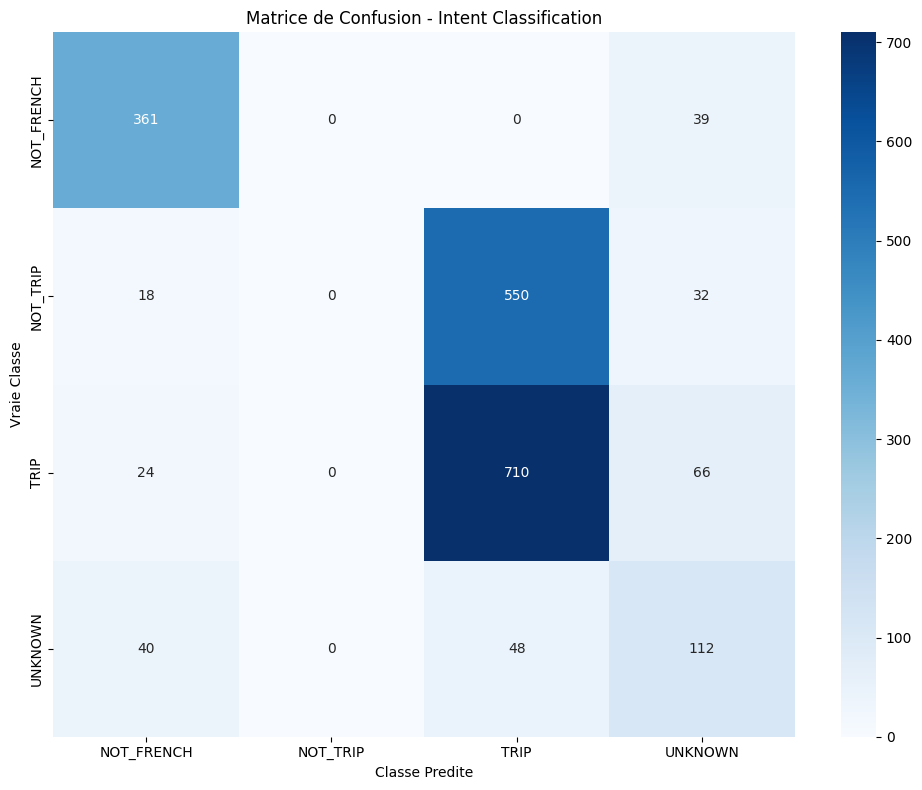


Modele sauvegarde dans: /content/drive/MyDrive/dataset/models/intent_classifier_best


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluer sur le test set
eval_results = intent_trainer.evaluate()

print('='*70)
print('RESULTATS SUR LE TEST SET')
print('='*70)
for key, value in eval_results.items():
    if isinstance(value, float):
        print(f'  {key}: {value:.4f}')

# Predictions detaillees
predictions = intent_trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids


# Ajouter post-processing
def post_process_prediction(text, predicted_intent):
    """
    Corrige les predictions aberrantes avec regles heuristiques.
    """
    text_lower = text.lower().strip()

    # Detection langue
    try:
        from langdetect import detect
        lang = detect(text) if len(text) >= 3 else 'unknown'
    except:
        lang = 'fr'  # Par defaut francais

    # REGLE 1: Langue non-francaise
    english_markers = ['i ', 'you ', 'the ', 'is ', 'are ', 'have ', 'do ', 'can ', 'hello', 'please']
    spanish_markers = ['el ', 'la ', 'los ', 'de ', 'que ', 'por ', 'para ', 'bueno', 'gracias']
    german_markers = ['der ', 'die ', 'das ', 'ist ', 'ich ', 'sie ', 'haben ', 'guten', 'danke']

    if (lang not in ['fr', 'unknown']) or \
       any(marker in text_lower for marker in english_markers + spanish_markers + german_markers):
        if predicted_intent != 'NOT_FRENCH':
            return 'NOT_FRENCH'

    # REGLE 2: Mots-cles NOT_TRIP
    not_trip_keywords = [
        'merci', 'remercie', 'confirme', 'email', 'reunion', 'document',
        'rapport', 'felicitation', 'bravo', 'compte-rendu', 'transferer'
    ]
    if any(kw in text_lower for kw in not_trip_keywords):
        trip_keywords = ['billet', 'train', 'aller', 'retour', 'trajet']
        has_trip = any(kw in text_lower for kw in trip_keywords)
        if not has_trip and predicted_intent == 'TRIP':
            return 'NOT_TRIP'

    # REGLE 3: Texte incomprehensible (tres court, pas de mots francais)
    if len(text_lower) < 15 and lang == 'unknown':
        words = text_lower.split()
        if len(words) <= 3:
            # Verifier si ce sont des mots francais reconnaissables
            french_common = ['de', 'a', 'le', 'la', 'pour', 'je', 'tu', 'il']
            if not any(word in french_common for word in words):
                if predicted_intent != 'UNKNOWN':
                    return 'UNKNOWN'

    # REGLE 4: Format "Ville1 Ville2" = TRIP
    words = text_lower.split()
    if len(words) == 2 and len(text) < 50:
        # Verifier si ce sont deux noms propres (majuscules)
        if text.split()[0][0].isupper() and text.split()[1][0].isupper():
            if predicted_intent != 'TRIP':
                return 'TRIP'

    # REGLE 5: Presence "de X a Y" ou "X Y" = TRIP
    if ('de ' in text_lower and ' a ' in text_lower) or \
       ('de ' in text_lower and ' vers ' in text_lower) or \
       (' pour ' in text_lower and len(words) < 10):
        trip_keywords = ['billet', 'train', 'horaire', 'tarif']
        not_trip_keywords_strict = ['merci', 'document', 'rapport']
        has_not_trip = any(kw in text_lower for kw in not_trip_keywords_strict)
        if not has_not_trip and predicted_intent != 'TRIP':
            return 'TRIP'

    return predicted_intent

# Appliquer post-processing
test_df_eval = test_df.copy()
test_df_eval['predicted_label'] = predicted_labels
test_df_eval['predicted_intent'] = label_encoder.inverse_transform(predicted_labels)

corrected_intents = []
for idx, row in test_df_eval.iterrows():
    corrected = post_process_prediction(row['text'], row['predicted_intent'])
    corrected_intents.append(corrected)

test_df_eval['corrected_intent'] = corrected_intents
test_df_eval['corrected_label'] = label_encoder.transform(corrected_intents)

# Comparer
accuracy_before = (test_df_eval['label'] == test_df_eval['predicted_label']).mean()
accuracy_after = (test_df_eval['label'] == test_df_eval['corrected_label']).mean()

print(f'\\nAccuracy avant post-processing: {accuracy_before:.4f}')
print(f'Accuracy apres post-processing: {accuracy_after:.4f}')
print(f'Amelioration: {(accuracy_after - accuracy_before):.4f} ({(accuracy_after/accuracy_before - 1)*100:+.2f}%)')

# Classification report apres PP
from sklearn.metrics import classification_report
print('\\n' + '='*70)
print('CLASSIFICATION REPORT APRES POST-PROCESSING')
print('='*70)
print(classification_report(
    test_df_eval['label'],
    test_df_eval['corrected_label'],
    target_names=label_encoder.classes_,
    digits=4
))

# Classification report
print('\n' + '='*70)
print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=label_encoder.classes_,
    digits=4
))

# Matrice de confusion
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matrice de Confusion - Intent Classification')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Predite')
plt.tight_layout()
plt.show()

# Sauvegarder le modele
model_path = os.path.join(workdir, 'models/intent_classifier_best')
intent_trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

print(f'\nModele sauvegarde dans: {model_path}')

## Preparation du dataset NER (Token Classification)

Conversion des annotations en format BIO pour le NER contextuel avec Transformers.

In [8]:
from transformers import AutoTokenizer

# Tokenizer rapide pour NER
tokenizer_fast = AutoTokenizer.from_pretrained('camembert-base', use_fast=True)

# Labels NER en format BIO
ner_labels = ['O', 'B-Departure', 'I-Departure', 'B-Destination', 'I-Destination']
label2id = {label: i for i, label in enumerate(ner_labels)}
id2label = {i: label for label, i in label2id.items()}

print('Labels NER:')
for label_id, label_name in id2label.items():
    print(f'  {label_id}: {label_name}')

def convert_to_bio_tags(text, entities):
    """Convertit les annotations en tags BIO pour chaque token."""
    encoding = tokenizer_fast(
        text,
        return_offsets_mapping=True,
        truncation=True,
        max_length=128,
        padding='max_length'
    )

    offset_mapping = encoding['offset_mapping']
    labels = ['O'] * len(offset_mapping)

    for entity in entities:
        start_char = entity['start']
        end_char = entity['end']
        entity_label = entity['label']

        token_indices = []
        for idx, (token_start, token_end) in enumerate(offset_mapping):
            if token_start == token_end == 0:
                continue
            if not (token_end <= start_char or token_start >= end_char):
                token_indices.append(idx)

        if token_indices:
            labels[token_indices[0]] = f'B-{entity_label}'
            for idx in token_indices[1:]:
                labels[idx] = f'I-{entity_label}'

    label_ids = [label2id.get(label, 0) for label in labels]

    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': label_ids
    }

# Preparer les datasets NER
print('\nConversion en format BIO...')
ner_train_data = []
for _, row in train_df.iterrows():
    entities = row['parsed_entities'] if row['intent'] == 'TRIP' else []
    ner_example = convert_to_bio_tags(row['text'], entities)
    ner_train_data.append(ner_example)

ner_test_data = []
for _, row in test_df.iterrows():
    entities = row['parsed_entities'] if row['intent'] == 'TRIP' else []
    ner_example = convert_to_bio_tags(row['text'], entities)
    ner_test_data.append(ner_example)

ner_train_dataset = Dataset.from_list(ner_train_data)
ner_test_dataset = Dataset.from_list(ner_test_data)

print(f'Datasets NER crees:')
print(f'  Train: {len(ner_train_dataset)} exemples')
print(f'  Test: {len(ner_test_dataset)} exemples')

Labels NER:
  0: O
  1: B-Departure
  2: I-Departure
  3: B-Destination
  4: I-Destination

Conversion en format BIO...
Datasets NER crees:
  Train: 8000 exemples
  Test: 2000 exemples


## Fine-Tuning NER avec CamemBERT

Entrainement du modele NER pour extraire Departure et Destination de maniere contextuelle.

In [9]:
from transformers import (
    AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
import evaluate

# Charger le modele CamemBERT pour Token Classification
ner_model = AutoModelForTokenClassification.from_pretrained(
    'camembert-base',
    num_labels=len(ner_labels),
    id2label=id2label,
    label2id=label2id
)

# Data collator
data_collator = DataCollatorForTokenClassification(tokenizer_fast)

# Metrique seqeval
seqeval_metric = evaluate.load('seqeval')

def compute_ner_metrics(eval_pred):
    """Calcule les metriques NER avec seqeval."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    true_labels = []
    pred_labels = []

    for pred_seq, label_seq in zip(predictions, labels):
        true_tags = []
        pred_tags = []

        for pred_id, label_id in zip(pred_seq, label_seq):
            if label_id != -100:
                true_tags.append(id2label[label_id])
                pred_tags.append(id2label[pred_id])

        true_labels.append(true_tags)
        pred_labels.append(pred_tags)

    results = seqeval_metric.compute(predictions=pred_labels, references=true_labels)

    return {
        'precision': results['overall_precision'],
        'recall': results['overall_recall'],
        'f1': results['overall_f1'],
        'accuracy': results['overall_accuracy']
    }

# Arguments d'entrainement
ner_training_args = TrainingArguments(
    output_dir=os.path.join(workdir, 'models/ner_model'),
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    logging_steps=100,
    warmup_steps=200,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
    report_to='none',
)

# Creer le Trainer
ner_trainer = Trainer(
    model=ner_model,
    args=ner_training_args,
    train_dataset=ner_train_dataset,
    eval_dataset=ner_test_dataset,
    tokenizer=tokenizer_fast,
    data_collator=data_collator,
    compute_metrics=compute_ner_metrics
)

print('\n' + '='*70)
print('DEBUT DU FINE-TUNING NER')
print('='*70)

# Entrainer le modele
ner_trainer.train()

print('\nFine-tuning NER termine!')

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-100512816.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ner_trainer = Trainer(



DEBUT DU FINE-TUNING NER


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.012300,0.010099,1.000000,1.000000,1.000000,1.000000
2,0.004400,0.003708,1.000000,1.000000,1.000000,1.000000
3,0.002600,0.002257,1.000000,1.000000,1.000000,1.000000
4,0.002200,0.001877,1.000000,1.000000,1.000000,1.000000



Fine-tuning NER termine!


## Evaluation du modele NER

Evalue le modele NER avec metriques detaillees par entite.

In [10]:
from seqeval.metrics import classification_report as seqeval_report

# Evaluer sur le test set
ner_eval_results = ner_trainer.evaluate()

print('='*70)
print('RESULTATS NER SUR LE TEST SET')
print('='*70)
for key, value in ner_eval_results.items():
    if isinstance(value, float):
        print(f'  {key}: {value:.4f}')

# Predictions detaillees
ner_predictions = ner_trainer.predict(ner_test_dataset)
predicted_logits = ner_predictions.predictions
predicted_labels = np.argmax(predicted_logits, axis=-1)
true_labels = ner_predictions.label_ids

# Convertir en tags pour seqeval
true_tags_list = []
pred_tags_list = []

for pred_seq, label_seq in zip(predicted_labels, true_labels):
    true_tags = []
    pred_tags = []

    for pred_id, label_id in zip(pred_seq, label_seq):
        if label_id != -100:
            true_tags.append(id2label[label_id])
            pred_tags.append(id2label[pred_id])

    true_tags_list.append(true_tags)
    pred_tags_list.append(pred_tags)

# Classification report detaille
print('\n' + '='*70)
print('CLASSIFICATION REPORT NER (par entite)')
print('='*70)
print(seqeval_report(true_tags_list, pred_tags_list, digits=4))

# Sauvegarder le modele
ner_model_path = os.path.join(workdir, 'models/ner_model_best')
ner_trainer.save_model(ner_model_path)
tokenizer_fast.save_pretrained(ner_model_path)

print(f'\nModele NER sauvegarde dans: {ner_model_path}')

RESULTATS NER SUR LE TEST SET
  eval_loss: 0.0101
  eval_precision: 1.0000
  eval_recall: 1.0000
  eval_f1: 1.0000
  eval_accuracy: 1.0000
  eval_runtime: 7.4679
  eval_samples_per_second: 267.8120
  eval_steps_per_second: 16.7380
  epoch: 4.0000

CLASSIFICATION REPORT NER (par entite)
              precision    recall  f1-score   support

   Departure     1.0000    1.0000    1.0000       800
 Destination     1.0000    1.0000    1.0000       800

   micro avg     1.0000    1.0000    1.0000      1600
   macro avg     1.0000    1.0000    1.0000      1600
weighted avg     1.0000    1.0000    1.0000      1600


Modele NER sauvegarde dans: /content/drive/MyDrive/dataset/models/ner_model_best


## Pipeline d'inference complet avec Transformers

Combine Intent Classification + NER pour predictions completes.

In [12]:
from transformers import pipeline

# Charger les pipelines
print('Chargement des modeles...')

intent_model_path = os.path.join(workdir, 'models/intent_classifier_best')
ner_model_path = os.path.join(workdir, 'models/ner_model_best')

intent_pipeline = pipeline(
    'text-classification',
    model=intent_model_path,
    tokenizer=intent_model_path,
    device=0 if torch.cuda.is_available() else -1
)

ner_pipeline = pipeline(
    'token-classification',
    model=ner_model_path,
    tokenizer=ner_model_path,
    aggregation_strategy='simple',
    device=0 if torch.cuda.is_available() else -1
)

print('Pipelines charges!')

def predict_travel_order(sentence_id, text):
    """Pipeline complet : Intent + NER"""
    # 1. Predire l'intent
    intent_result = intent_pipeline(text)[0]
    predicted_intent = intent_result['label']
    confidence = intent_result['score']

    # 2. Si pas TRIP, retourner l'intent
    if predicted_intent != 'TRIP':
        return f"{sentence_id},{predicted_intent}", confidence

    # 3. Si TRIP, extraire les entites
    ner_results = ner_pipeline(text)

    departure = None
    destination = None

    for entity in ner_results:
        entity_label = entity.get('entity_group', entity.get('entity'))
        word = entity['word'].replace('▁', ' ').strip()

        if 'Departure' in entity_label and not departure:
            departure = word
        elif 'Destination' in entity_label and not destination:
            destination = word

    if departure and destination:
        return f"{sentence_id},{departure},{destination}", confidence
    else:
        return f"{sentence_id},UNKNOWN", confidence

# Tester sur les exemples problematiques mentionnes
print('\n' + '='*70)
print('TESTS SUR EXEMPLES PROBLEMATIQUES')
print('='*70)

test_examples = [
    ("4740", "Bonjour, je compte faire le trajet vendredi de Cotonou à Porto-Novo"),
    ("5606", "À quelle heure y a-t-il des trains de Martigues à Lyon ?"),
    ("4824", "Comment aller de Malanville à Caen ?"),
    ("4205", "Is there a train to Manchester?"),
    ("3228", "de Semur-en-Auxois à Dreux"),
    ("2745", "Billet Les Sables-d'Olonne à Château-Chinon")
]

for sid, text in test_examples:
    result, conf = predict_travel_order(sid, text)
    print(f'\n{sid}: {text}')
    print(f'  -> Prediction: {result}')
    print(f'  -> Confiance: {conf:.2%}')

Chargement des modeles...


Device set to use cuda:0
Device set to use cuda:0


Pipelines charges!

TESTS SUR EXEMPLES PROBLEMATIQUES

4740: Bonjour, je compte faire le trajet vendredi de Cotonou à Porto-Novo
  -> Prediction: 4740,Cotonou,Porto-Novo
  -> Confiance: 29.32%

5606: À quelle heure y a-t-il des trains de Martigues à Lyon ?
  -> Prediction: 5606,UNKNOWN
  -> Confiance: 27.09%

4824: Comment aller de Malanville à Caen ?
  -> Prediction: 4824,Malanville,Caen
  -> Confiance: 26.93%

4205: Is there a train to Manchester?
  -> Prediction: 4205,NOT_FRENCH
  -> Confiance: 25.49%

3228: de Semur-en-Auxois à Dreux
  -> Prediction: 3228,Semur-en-Auxois,Dreux
  -> Confiance: 27.70%

2745: Billet Les Sables-d'Olonne à Château-Chinon
  -> Prediction: 2745,UNKNOWN
  -> Confiance: 28.37%
